# Benchmarking

## 1. Prepare working environment

In [2]:
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

from scripts import Worker

In [3]:
!nvidia-smi

Wed Apr 19 04:14:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:52:00.0 Off |                  N/A |
| 30%   31C    P8    28W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Datasets and visulisation

In [5]:
class MyDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.data_info = self.get_img_info(data_dir)
        self.transforms = transforms

    def __getitem__(self, item):
        path_img, label = self.data_info.iloc[item][1:3]
        label = int(label)
        path_img = os.path.join(self.data_dir, path_img)
        image = Image.open(path_img).convert('RGB')
        # 使用定义好的transforms，对数据进行处理
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.data_info)
    
    def get_img_info(self, data_dir):
        path_dir = os.path.join(data_dir, 'label.csv')
        return pd.read_csv(path_dir)

In [6]:
dataset_folder = "dataset02"

transform = transforms.Compose(
    [transforms.ToTensor()])
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

trainset = MyDataset(f"data/train/{dataset_folder}", transform)
testset = MyDataset(f"data/test/{dataset_folder}", transform)

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=8)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=8)

classes = (0, 1)

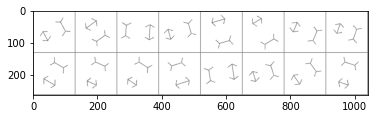

    1     0     0     1     0     1     1     1     0     1     1     0     0     1     0     1


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))


## 3. Model and training

In [7]:
timm.list_models('dense*', pretrained=True)

['densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d']

In [8]:
exp_name = f"{dataset_folder}_benchmarking"
model_names = ['xception','densenet201','resnetv2_50', 'vgg16', 'darknet53', 'mobilenetv3_large_100', 'inception_resnet_v2', 'nasnetalarge', 'efficientnetv2_rw_m', 'convnext_xlarge_384_in22ft1k']
print(len(model_names))

10


In [9]:
for model_name in model_names:
    print(f"Log: {model_name}")
    model = timm.create_model(model_name, num_classes=2)
    worker = Worker(exp_name, model_name, model, trainloader, testloader, epochs=1)
    worker.train()

Log: xception


epoch,train_loss,valid_loss,accuracy,time
0,0.213996,0.483628,0.732500,00:41


epoch,train_loss,valid_loss,accuracy,time
0,0.104897,0.055952,0.984000,00:41


Log: densenet201


epoch,train_loss,valid_loss,accuracy,time
0,0.291274,0.972676,0.698500,02:25


epoch,train_loss,valid_loss,accuracy,time
0,0.076878,0.053342,0.983000,02:22


Log: resnetv2_50


epoch,train_loss,valid_loss,accuracy,time
0,0.265785,3.197129,0.406500,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.079932,0.039446,0.987500,00:45


Log: vgg16


epoch,train_loss,valid_loss,accuracy,time
0,1.381740,0.612987,0.698500,00:41


epoch,train_loss,valid_loss,accuracy,time
0,0.605696,0.612510,0.698500,00:41


Log: darknet53


epoch,train_loss,valid_loss,accuracy,time
0,0.331198,21.458069,0.698500,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.170424,0.109246,0.963000,00:47


Log: mobilenetv3_large_100


epoch,train_loss,valid_loss,accuracy,time
0,1.945657,12.635863,0.685500,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.149708,0.094320,0.964500,00:46


Log: inception_resnet_v2


epoch,train_loss,valid_loss,accuracy,time
0,0.208844,0.286469,0.891500,02:29


epoch,train_loss,valid_loss,accuracy,time
0,0.086531,0.055899,0.982500,02:29


Log: nasnetalarge


epoch,train_loss,valid_loss,accuracy,time
0,0.440684,0.519572,0.658500,03:07


epoch,train_loss,valid_loss,accuracy,time
0,0.100167,0.069114,0.981500,03:08


Log: efficientnetv2_rw_m


epoch,train_loss,valid_loss,accuracy,time
0,1.077907,0.814573,0.698500,02:26


epoch,train_loss,valid_loss,accuracy,time
0,0.634176,0.608969,0.698500,02:23


Log: convnext_xlarge_384_in22ft1k


epoch,train_loss,valid_loss,accuracy,time
0,0.625550,0.612620,0.698500,01:50


epoch,train_loss,valid_loss,accuracy,time
0,0.596240,0.613184,0.698500,01:50


## 4. Metrics

In [16]:
from fastai.vision import *
from fastai.data.transforms import *


exp_name = f"{dataset_folder}_benchmarking"
model_names = ['xception','densenet201','resnetv2_50', 'vgg16', 'darknet53', 'mobilenetv3_large_100', 'inception_resnet_v2', 'nasnetalarge', 'efficientnetv2_rw_m', 'convnext_xlarge_384_in22ft1k']
benchmark_dict = {}

for model_name in model_names:
    print(model_name)
    
    if os.path.exists(f"models/{exp_name}/{model_name}_eval.csv"):
        benchmark_dict[model_name] = pd.read_csv(f"models/{exp_name}/{model_name}_eval.csv")
        continue
        
    benchmark_dict[model_name] = pd.DataFrame(columns = ["value", "type"])
    
    state_dict = torch.load(f"models/{exp_name}/{model_name}.pt")

    model = timm.create_model(model_name, num_classes=2).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    # worker = Worker(exp_name, model_name, model, trainloader, testloader)
    # worker.eval()
    
    path_dir = os.path.join(f"data/test/{dataset_folder}", 'label.csv')
    info_df = pd.read_csv(path_dir)

    testiter = iter(testloader)

    for i in range(info_df.size-1):
        images, labels = next(testiter, (None, None))

        if images == None or labels == None:
            break

        if dataset_folder == "dataset01":
            pass
        elif dataset_folder == "dataset02":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3]
        elif dataset_folder == "dataset04":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3] - info_df.iloc[i][4]
        images = images.to(device)
        
        # pred = worker.learner.model(images).argmax(1)[0]
        pred = model(images).argmax(1)[0]
        
        if (pred != label):
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FN'
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FP'
                
        else:
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TN'
                
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TP'
    
    for k, v in benchmark_dict.items():
        v.to_csv(f"models/{exp_name}/{k}_eval.csv")    

xception
densenet201
resnetv2_50
vgg16
darknet53
mobilenetv3_large_100
inception_resnet_v2
nasnetalarge
efficientnetv2_rw_m
convnext_xlarge_384_in22ft1k


In [17]:
for type_name in ['TP', 'TN', 'FP', 'FN']:
    print(type_name)
    for model_name in model_names:
        print(len(benchmark_dict[model_name][benchmark_dict[model_name]['type'] == type_name]))

TP
603
603
601
0
602
602
597
602
0
0
TN
1365
1363
1374
1397
1324
1327
1368
1361
1397
1397
FP
0
0
2
603
1
1
6
1
603
603
FN
32
34
23
0
73
70
29
36
0
0


In [18]:
for type_name in ['FN']:
    print(f"{type_name}_std")
    for model_name in model_names:
        print(benchmark_dict[model_name][benchmark_dict[model_name]['type'] == type_name]['value'].std())

FN_std
0.015324941456500292
0.014899933603555902
0.014279397248159706
nan
0.03311960016008767
0.025530171327923484
0.01478441130833386
0.012712823172524387
nan
nan


/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


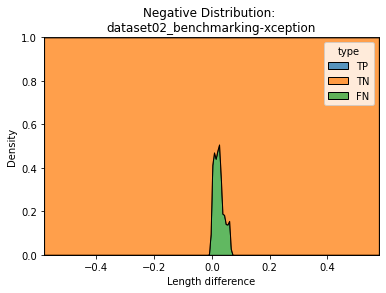

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


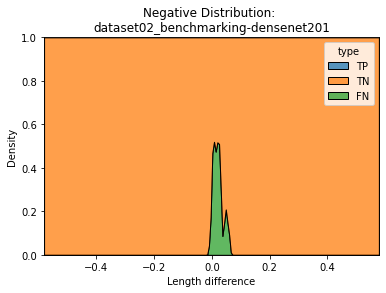

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


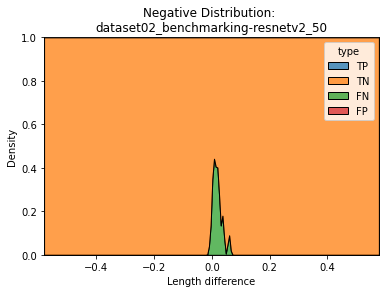

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


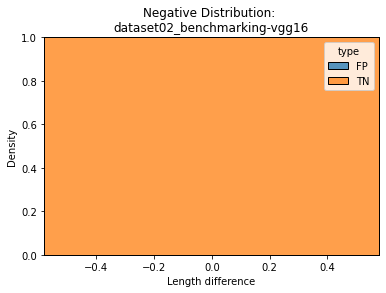

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


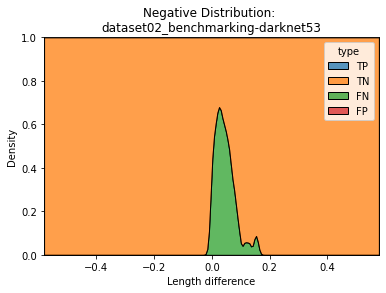

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


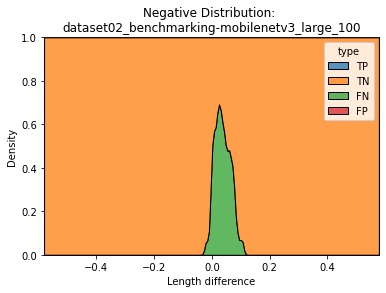

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


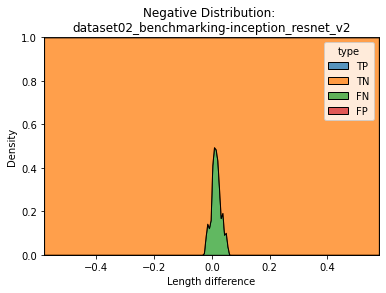

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


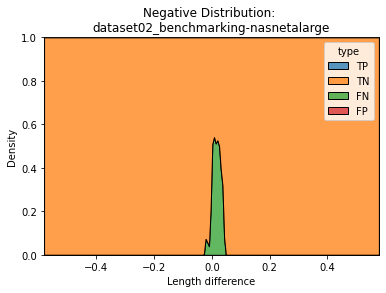

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


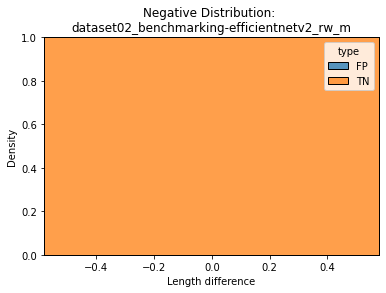

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


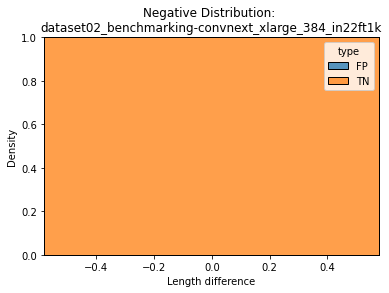

In [20]:
import seaborn as sns

for model_name in model_names:
    sns.kdeplot(data=benchmark_dict[model_name], x='value', hue='type', multiple='fill', bw_adjust = 0.5)

    # plt.legend(['False Negative', 'True Negative'])
    plt.xlabel ("Length difference");
    # plt.ylabel ("");
    plt.title (f"Negative Distribution: \n{exp_name}-{model_name}");
    plt.show()

## 5. Cross evaluation

In [10]:
from fastai.vision import *
from fastai.data.transforms import *


exp_name = f"model04x{dataset_folder}_benchmarking"
model_exp_name = f"dataset04_benchmarking"
model_names = ['xception','densenet201','resnetv2_50', 'vgg16', 'darknet53', 'mobilenetv3_large_100', 'inception_resnet_v2', 'nasnetalarge', 'efficientnetv2_rw_m', 'convnext_xlarge_384_in22ft1k']
benchmark_dict = {}

os.mkdir(f"models/{exp_name}")

for model_name in model_names:
    print(model_name)
    
    if os.path.exists(f"models/{exp_name}/{model_name}_eval.csv"):
        benchmark_dict[model_name] = pd.read_csv(f"models/{exp_name}/{model_name}_eval.csv")
        continue
        
    benchmark_dict[model_name] = pd.DataFrame(columns = ["value", "type"])
    
    state_dict = torch.load(f"models/{model_exp_name}/{model_name}.pt")

    model = timm.create_model(model_name, num_classes=2).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    # worker = Worker(exp_name, model_name, model, trainloader, testloader)
    # worker.eval()
    
    path_dir = os.path.join(f"data/test/{dataset_folder}", 'label.csv')
    info_df = pd.read_csv(path_dir)

    testiter = iter(testloader)

    for i in range(info_df.size-1):
        images, labels = next(testiter, (None, None))

        if images == None or labels == None:
            break

        if dataset_folder == "dataset01":
            pass
        elif dataset_folder == "dataset02":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3]
        elif dataset_folder == "dataset04":
            label = info_df.iloc[i][2]
            value = info_df.iloc[i][3] - info_df.iloc[i][4]
        images = images.to(device)
        
        # pred = worker.learner.model(images).argmax(1)[0]
        pred = model(images).argmax(1)[0]
        
        if (pred != label):
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FN'
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'FP'
                
        else:
            if (label == 0):
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TN'
                
            else:
                benchmark_dict[model_name].loc[len(benchmark_dict[model_name]), benchmark_dict[model_name].columns] = value, 'TP'
    
    for k, v in benchmark_dict.items():
        v.to_csv(f"models/{exp_name}/{k}_eval.csv")    

xception
densenet201
resnetv2_50
vgg16
darknet53
mobilenetv3_large_100
inception_resnet_v2
nasnetalarge
efficientnetv2_rw_m
convnext_xlarge_384_in22ft1k


/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


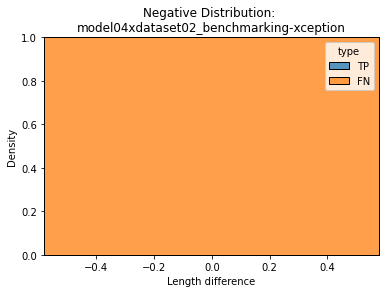

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


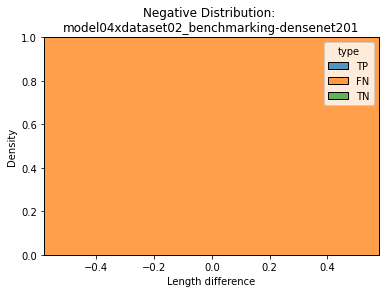

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


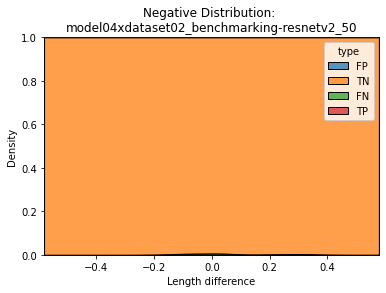

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


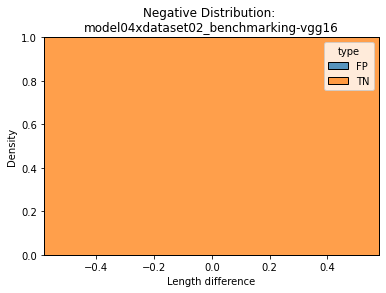

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


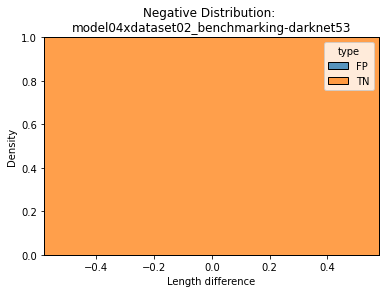

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


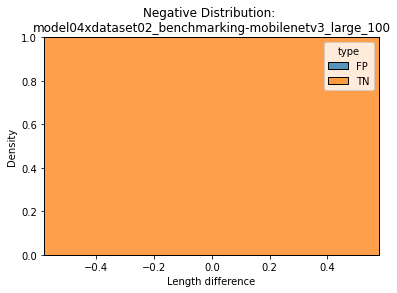

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


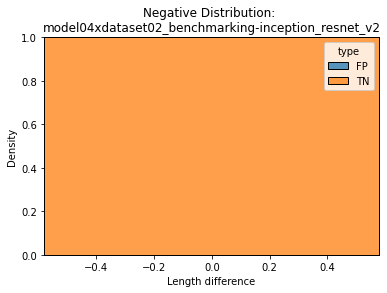

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


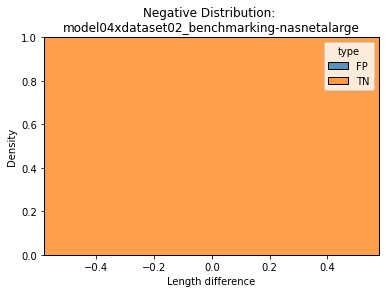

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


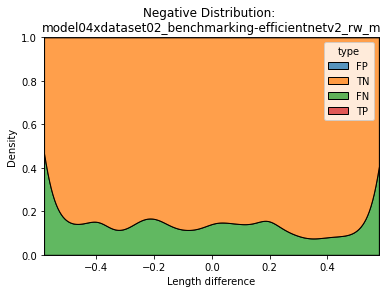

/root/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


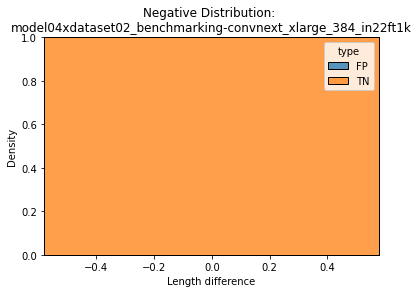

In [11]:
import seaborn as sns

for model_name in model_names:
    sns.kdeplot(data=benchmark_dict[model_name], x='value', hue='type', multiple='fill', bw_adjust = 0.5)

    # plt.legend(['False Negative', 'True Negative'])
    plt.xlabel ("Length difference");
    # plt.ylabel ("");
    plt.title (f"Negative Distribution: \n{exp_name}-{model_name}");
    plt.show()